### Heston

$$ dS_{t}  = \mu S_{t} dt + \sqrt{V_{t}} S_{t} dW_{t}$$

$$ dV_{t} = k(\theta - \bar{V_{t}})dt + \sigma \sqrt{V_{t}} dZ_{t}$$

+ T = 30 / 365
+ n = 30
+ L = 3,N0= 2d,N1=N2=d+ 15, 3 layer, 2d, d + 15, d + 15 units
+ larger learning rate, the tech-nique of batch normalizatio
+ Relu activation

Heston Parameters

$dS_{t} = \sqrt{V_{t}} S_{t} dB_{t}$

$dV_{t} = \alpha(b - V_{t}) dt + \sigma \sqrt{V_{t}} dW_{t} $

+ $\alpha = 1, b = 0.04, \sigma = 2, v_{0} =  0.04$

+ Exact simulation of CIR


Glasserman Chapter 3, page 124

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cmath
plt.style.use("fivethirtyeight")
import seaborn as sns
!rm -rf Mean-Variance-Hedging
!git clone https://github.com/chrischia06/Mean-Variance-Hedging

import sys
sys.path.append("Mean-Variance-Hedging/")
from mean_variance_hedge.dynamic_programming import *
from mean_variance_hedge.black_scholes import *
from mean_variance_hedge.heston import *
from mean_variance_hedge.utils import *


Cloning into 'Mean-Variance-Hedging'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 75 (delta 22), reused 67 (delta 18), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [ ]:
####################
#    PARAMETERS    #
####################

N_SAMPLES = 10 ** 5


alpha = 1 # speed of mean reversion
b  = 0.04 #log-run variance
sigma = 2 # vol-of variance
dt = 1 / 250 # time increment, years
v_0 = 0.04 # intial estimate of variance 
T = 30 #time steps

tis = np.arange(T + 1) #0, 1 .. T
tis = np.tile(tis, N_SAMPLES).reshape(N_SAMPLES, T + 1) # [[0, 1.. T], [0, 1.. T]...]

S0 = 100
rho = -0.7
r = 0 # risk free rate
rf = 1 + r #risk-free return


K_strike = 100
CALL = 1


In [ ]:
Sts, Vts = generate_Heston_paths(n_samples = N_SAMPLES, S0 = 100, rho = -0.7, 
                                 r = 0, alpha = alpha, b = b, 
                                 sigma = sigma, dt = dt, 
                                 v_0 = v_0, T = T, seed = 2021)

In [ ]:
Heston_MC_price = np.mean(np.maximum(Sts[:, T] - K_strike, 0))
imp_vol = bsinv(Heston_MC_price, St = S0, K = K_strike, r = r, tau = T / 250, flag = 1)
print(f"Monte Carlo Heston Price: {Heston_MC_price}")
print(f"Implied Volatility {imp_vol} (BS-Price under imp vol: {BlackScholes(S0, K_strike, r, imp_vol, T * dt, 1)})")

Monte Carlo Heston Price: 1.8989713424445749
Implied Volatility 0.13742277963359376 (BS-Price under imp vol: 1.8989713424445753)


Calibrate log-returns for the Dynamic Programming method based on log-returns from t = 0, 1

[-0.065  0.048]


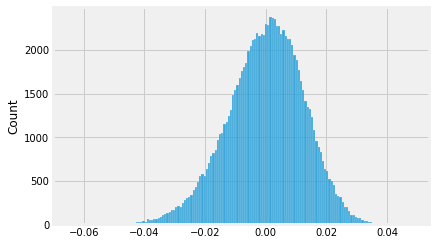

In [ ]:
observed_rets = np.log(Sts[:,1] / Sts[:,0])
fig, ax = plt.subplots()
sns.histplot(observed_rets, ax=ax)
bounds = np.round([observed_rets.min(), observed_rets.max()], 3)
print(bounds)

In [ ]:
scale_factor = 10 ** 3

N_discrete_states = 10
bins = np.linspace(bounds[0], bounds[1], N_discrete_states + 1)
counts, val = np.histogram(observed_rets, bins=bins)
p_probs = counts / np.sum(counts)

log_ret_space = [round((bins[i] + bins[i + 1]) / 2, 3) for i in range(len(bins) - 1)]
log_ret_space2 = [round(x * scale_factor) for x in log_ret_space]
ret_space = np.exp(log_ret_space) # returns
a, b, m, q_probs = calc_variance_optimal_measure(ret_space, rf, p_probs)
print("Discretised Log-Returns space:",log_ret_space)
print("Variance Optimal probabilities:",np.round(q_probs, 4))

attainable_nodes = possible_nodes(log_ret_space, T, scale_factor)
Hts = calc_mean_value_process(attainable_nodes, S0, K_strike, rf, log_ret_space, T, scale_factor, q_probs)
dynamic_delta = calc_dynamic_deltas(attainable_nodes, Hts, S0, rf, log_ret_space, T, scale_factor, q_probs)    

Discretised Log-Returns space: [-0.059, -0.048, -0.037, -0.025, -0.014, -0.003, 0.008, 0.02, 0.031, 0.042]
Variance Optimal probabilities: [2.000e-04 1.700e-03 1.100e-02 5.250e-02 1.723e-01 3.293e-01 3.076e-01
 1.116e-01 1.340e-02 5.000e-04]


Calculate Black-Scholes, Dynamic Programming and Locally Optimal Hedge along Monte Carlo Paths

In [ ]:
%%time

heston_vals = np.zeros((N_SAMPLES, T + 1))
bs_vals = np.zeros((N_SAMPLES, T + 1))
dynamic_vals = np.zeros((N_SAMPLES, T + 1))
local_vals = np.zeros((N_SAMPLES, T + 1))




bs_vals[:,0] = Heston_MC_price
dynamic_vals[:,0] = Heston_MC_price
local_vals[:,0] = Heston_MC_price
heston_vals[:,0] = Heston_MC_price

# heston_deltas = np.zeros((N_SAMPLES, T))
bs_deltas = np.zeros((N_SAMPLES, T))
dynamic_deltas = np.zeros((N_SAMPLES, T ))
local_deltas = np.zeros((N_SAMPLES, T ))



# heston_deltas[:, 0] = calc_Heston_delta_by_FD(kappa = 1, theta = 0.04, sigma = 2, rho = -0.7, r = 0, 
#                         s0 = S0, v0 = 0.04, K= K_strike, tau = (T - 0) * dt)
dynamic_deltas[:, 0] = dynamic_delta[0][0]
local_deltas[:,0] = dynamic_delta[0][0] + rf * a * (Hts[0][0] - Heston_MC_price) / S0

attainable_rets = {t:np.array(list(attainable_nodes[t])) for t in range(T + 1)}

for i in range(N_SAMPLES):
  for t in range(1, T):
    current_node = attainable_rets[t][np.abs(attainable_rets[t] - (np.log(Sts[i,t] / S0) * scale_factor)).argmin()]
    dynamic_deltas[i, t] = dynamic_delta[t][current_node]
    # adjustment require for the locally-optimal hedging value
    local_vals[i, t] = (rf * local_vals[i, t - 1] + 
                        local_deltas[i, t - 1] * (Sts[i, t] - rf * Sts[i, t - 1]))
    local_deltas[i, t] = (dynamic_delta[t][current_node] + 
                         rf * a * (Hts[t][current_node] - local_vals[i, t]) / Sts[i, t])
  local_vals[i, T] = (rf * local_vals[i, T - 1] + 
                      local_deltas[i, T - 1] * (Sts[i, T] - rf * Sts[i, T - 1]))
    
    
for i in range(N_SAMPLES):
  bs_deltas[i, :] = delta(Sts[i, :-1], K_strike, r, imp_vol, (T - tis[i,:-1]) * dt, CALL) # BS deltas

for t in range(1, T + 1):
  bs_vals[:, t] = rf * bs_vals[:, t - 1] + bs_deltas[:, t  - 1] * (Sts[:, t] - rf * Sts[: , t- 1])
  dynamic_vals[:, t] = rf * dynamic_vals[:, t - 1] + dynamic_deltas[:, t  - 1] * (Sts[:, t] - rf * Sts[: , t- 1])

# calculate terminal value = hedging portfolio value - (ST - K)+
bs_terminal_error = bs_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  
local_terminal_error = local_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  
dynamic_terminal_error = dynamic_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  

CPU times: user 54.1 s, sys: 30.8 ms, total: 54.1 s
Wall time: 54.2 s


Heston Model Hedge using Finite Differences

In [ ]:
%%time
for t in range(1, T):
  heston_deltas[:,t] = vec_fd(kappa = alpha, theta = b, sigma = sigma, rho = rho, r = r, 
                        s0 = Sts[:, t], v0 = v_0, K= K_strike, tau = (T - t) * dt)

CPU times: user 1h 7min 52s, sys: 10.2 s, total: 1h 8min 2s
Wall time: 1h 8min 16s


In [ ]:
heston_vals[:,0] = Heston_MC_price

for t in range(1, T + 1):
  heston_vals[:, t] = rf * heston_vals[:, t - 1] + heston_deltas[:, t  - 1] * (Sts[:, t] - rf * Sts[: , t- 1])

heston_terminal_error = heston_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  

In [ ]:
diagnosis(heston_terminal_error)

,MSHE,CVar 1%,CVaR 5%,CVar 10%,CVaR 50%
0,4.154632,10.467723,6.385729,4.766061,1.343923


# Deep Hedging

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def deep_hedger(T, n_feats):
    """
    Feed-Forward Neural Network
    """
    input_layer = Input(shape = (None, n_feats))
    # batch_norm = BatchNormalization()(input_layer)
    layer_1 = GRU(32, activation='tanh', 
                      kernel_initializer=initializers.RandomNormal(0,0.1),
                      bias_initializer=initializers.RandomNormal(0,0.1),
                  return_sequences=True
                  )(input_layer)
    # layer_2 = Dense(16, activation='relu',
    #                 kernel_initializer=initializers.RandomNormal())(batch_norm1)
    # batch_norm2 = BatchNormalization()(layer_2)
    # layer_3 = Dense(8, activation='relu', 
    #                 kernel_initializer = initializers.RandomNormal())(batch_norm2)
    # batch_norm3 = BatchNormalization()(layer_3)
    output_layer = Dense(1, activation='linear',
                         kernel_initializer=initializers.RandomNormal(),
                         bias_initializer=initializers.RandomNormal(0,0.1)
                         )(layer_1)
    model = Model(input_layer, output_layer)
    return model



In [ ]:
from sklearn.model_selection import train_test_split
X_true = np.log(Sts[:,:-1] / K_strike)
X_true = X_true.reshape((-1, T, 1))
y_true = Sts.reshape((-1, T + 1, 1))

# generate additional Heston paths, but NOT from the original observed paths
N_TRAIN_PATHS = 10 ** 5
train_paths, Vts2 = generate_Heston_paths(n_samples = N_SAMPLES, S0 = 100, rho = -0.7, 
                                 r = 0, alpha = alpha, b = b, 
                                 sigma = sigma, dt = dt, 
                                 v_0 = v_0, T = T, seed = 42)

X = np.log(train_paths / K_strike)

n_feats = 1
X2 = X[:, :-1].reshape((-1, T, n_feats))
y2 = train_paths.reshape((-1, T + 1, n_feats))

X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2, random_state = 42)

In [ ]:
def MSHE_Loss(init_price, strike, T):
    def lossFunction(y_true,y_pred):
      # for simplcity ignore rf for now, although this could be incorporated
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1)
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1)
      # print(tf.shape(price_changes))     
      # print(tf.shape(y_true)Z)
      option_val = tf.math.maximum(y_true[:,-1] - strike, 0)

      # val = (tf.math.reduce_sum(deltas * price_changes,axis=1))
      return tf.math.reduce_mean(tf.math.square(-option_val + val + init_price))
    return lossFunction

def cvarLoss(init_price, strike, T, batch_size, proportion = 0.01):
    num = int(batch_size * proportion)
    def lossFunction(y_true,y_pred):
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1)
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1)      
      option_val = tf.math.maximum(y_true[:,-1,:] - strike, 0)
      # top k worse - net value
      error = tf.reshape(-(-option_val + val + init_price), [-1])
      CVaR, idx = tf.math.top_k(error, tf.constant(num, dtype=tf.int32))
      # return tf.math.reduce_mean(CVaR)
      return tf.math.reduce_mean(CVaR)
    return lossFunction

In [ ]:
import os
import datetime
import tensorflow as tf
tf.random.set_seed(2021)

lr = 0.005
BATCH_SIZE = 256
EPOCHS = 50


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = deep_hedger(T, n_feats)
model.summary()
print("Check Model", model.predict(np.zeros((1, T, 1))).reshape(-1))

mshe_loss = MSHE_Loss(init_price=Heston_MC_price, strike=K_strike, T = T)
model.compile(optimizer=Adam(learning_rate=lr), loss=mshe_loss)
model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
          batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
          validation_data=(X_val, y_val), shuffle=False)

# cvar_loss = cvarLoss(init_price = Heston_MC_price, strike = K_strike, T = T, batch_size = BATCH_SIZE, proportion = 0.01)

# cvar_model = deep_hedger(T, n_feats)
# cvar_model.compile(optimizer=Adam(learning_rate=lr), loss=cvar_loss)
# cvar_model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
#           batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
#           validation_data=(X_val, y_val), shuffle=False)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gru (GRU)                    (None, None, 32)          3360      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
Check Model [-0.02293535 -0.00704249  0.00108805  0.00526644  0.00739373  0.00844738
  0.00894241  0.00915322  0.00922545  0.00923493  0.00921978  0.00919808
  0.00917754  0.00916084  0.00914831  0.00913939  0.00913328  0.00912921
  0.00912657  0.0091249   0.00912386  0.00912324  0.00912286  0.00912265
  0.00912253  0.00912246  0.00912243  0.00912242  0.00912242  0.00912242]
Epoch 1/50


In [ ]:
deep_hedge_deltas = np.zeros((N_SAMPLES, T))
deep_cvar_hedge_deltas = np.zeros((N_SAMPLES, T))

for i in range(T):
  temp= model.predict(X_true[:,:(i + 1),:], batch_size=512)
  deep_hedge_deltas[:,i] =  temp.reshape(-1, i + 1)[:,i]
  # temp2 = cvar_model.predict(X_true[:,:(i + 1),:], batch_size=512)
  # deep_cvar_hedge_deltas[:, i] = temp2.reshape(-1, i + 1)[:,i]

# calculate portfolio value
deep_vals = np.zeros((N_SAMPLES, T + 1))
deep_vals[:,0] = Heston_MC_price

# deep_cvar_vals = np.zeros((N_SAMPLES, T + 1))
# deep_cvar_vals[:,0] = Heston_MC_price


for t in range(1, T + 1):
    deep_vals[:, t] = rf * deep_vals[:, t - 1] + deep_hedge_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]) 
    # deep_cvar_vals[:, t] = rf * deep_cvar_vals[:, t - 1] + deep_cvar_hedge_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]) 
    

deep_terminal_error = deep_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)
# deep_cvar_terminal_error = deep_cvar_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)
  
  

# Plot Results

,MSHE,CVar 1%,CVaR 5%,CVar 10%,CVaR 50%
BS-delta,3.143079,9.524499,5.632385,4.089477,1.121566
Local Hedge,2.950864,8.677565,5.200123,3.862064,1.149328
Dynamic Hedge,2.956798,8.592913,5.178991,3.866077,1.154398
Deep-Hedger,2.524503,6.627313,4.422683,3.542721,1.151801


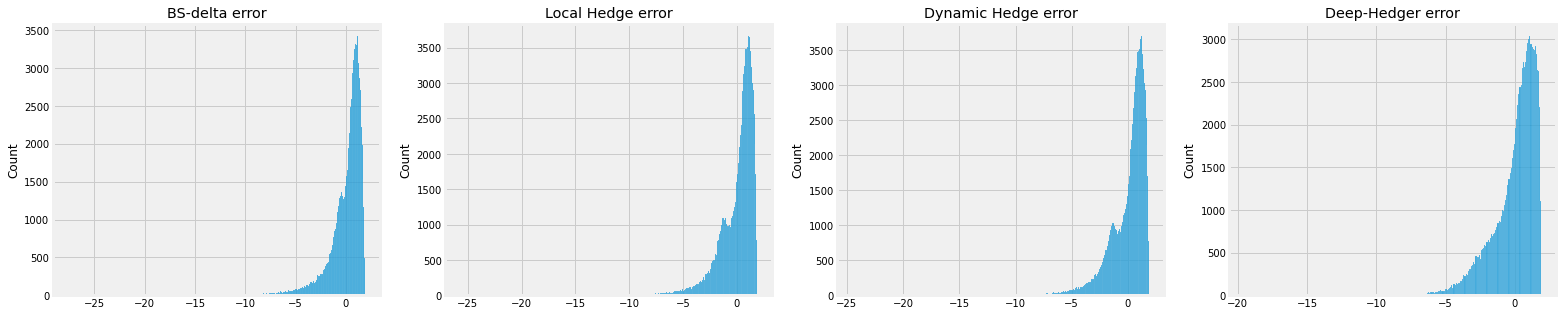

In [ ]:
hedging_errors = [bs_terminal_error, local_terminal_error, dynamic_terminal_error,
                  deep_terminal_error] #, deep_cvar_terminal_error]

hedging_errors2 = [diagnosis(error) for error in hedging_errors]
results = pd.concat(hedging_errors2)

titles = ["BS-delta", "Local Hedge", "Dynamic Hedge", ] + ["Deep-Hedger"]#, "Deep-CVaR-Hedger"]
results.index = titles
display(results)


plot_titles = [title +" error" for title in titles]
fig, ax = plt.subplots(ncols= len(titles), figsize=(len(titles) * 6, 5))
for i in range(len(titles)):
  sns.histplot(hedging_errors[i], ax=ax[i]).set_title(plot_titles[i]) 

In [ ]:
print(results.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      MSHE &   CVar 1\% &   CVaR 5\% &  CVar 10\% &  CVaR 50\% \\
\midrule
BS-delta      &  3.143079 &  9.524499 &  5.632385 &  4.089477 &  1.121566 \\
Local Hedge   &  2.950864 &  8.677565 &  5.200123 &  3.862064 &  1.149328 \\
Dynamic Hedge &  2.956798 &  8.592913 &  5.178991 &  3.866077 &  1.154398 \\
Deep-Hedger   &  2.524503 &  6.627313 &  4.422683 &  3.542721 &  1.151801 \\
\bottomrule
\end{tabular}



Test to make sure loss functions are correctly specified

In [ ]:
mshe_loss(y_true, bs_deltas.reshape(-1, T, 1))

<tf.Tensor: shape=(), dtype=float64, numpy=3.196536495150333>

In [ ]:
cvar_loss_test = cvarLoss(init_price = Heston_MC_price, strike = K_strike, T = T, batch_size = N_SAMPLES, proportion = 0.01)
cvar_loss_test(y_true, deep_cvar_hedge_deltas.reshape(-1, T, 1))

<tf.Tensor: shape=(), dtype=float64, numpy=6.644984989691031>

In [ ]:
    def characteristic_func(kappa, theta, sigma, rho, r, xi, s0, v0, tau):
        ixi = 1j * xi
        d = np.sqrt((kappa - ixi * rho * sigma)**2
                       + sigma**2 * (ixi + xi**2))
        g = (kappa - ixi * rho * sigma - d) / (kappa - ixi * rho * sigma + d)
        ee = cmath.exp(-d * tau)
        C = ixi * r * tau + kappa * theta / sigma**2 * (
            (kappa - ixi * rho * sigma - d) * tau - 2. * cmath.log((1 - g * ee) / (1 - g))
        )
        D = (kappa - ixi * rho * sigma - d) / sigma**2 * (
            (1 - ee) / (1 - g * ee)
        )
        return cmath.exp(C + D*v0 + ixi * cmath.log(s0))

    def integ_func(kappa, theta, sigma, rho, r, xi, s0, v0, K, tau, num):
        ixi = 1j * xi
        if num == 1:
            return (characteristic_func(kappa, theta, sigma, rho, r, xi - 1j, s0, v0, tau) / (ixi * characteristic_func(kappa, theta, sigma, rho, r, -1j, s0, v0, tau)) * cmath.exp(-ixi * cmath.log(K))).real
        else:
            return (characteristic_func(kappa, theta, sigma, rho, r, xi, s0, v0, tau) / (ixi) * cmath.exp(-ixi * cmath.log(K))).real

    def call_price(kappa, theta, sigma, rho, r, s0, v0, K, tau):
    
        "Simplified form, with only one integration. "
        h = lambda xi: s0 * integ_func(kappa, theta, sigma, rho, r, xi, s0, v0, K, tau, 1) - K * np.exp(-r * tau) * integ_func(kappa, theta, sigma, rho, r, xi, s0, v0, K, tau, 2)
        return 0.5 * (s0 - K * np.exp(-r * tau)) + 1/np.pi * scipy.integrate.quad(h, 1e-4, 500.)[0]

    def calc_Heston_delta_by_FD(kappa, theta, sigma, rho, r, s0, v0, K, tau):
        return (call_price(kappa, theta, sigma, rho, r, s0 + 0.0001, v0, K, tau) - 
                call_price(kappa, theta, sigma, rho, r, s0, v0, K, tau)) / 0.0001


    def calc_Heston_vega_by_FD(s0, v0, k, tau, pricer):
        " This is the sensitivity of price w.r.t variance, not to vega "
        dv = v0 * 0.001
        p_plus = pricer.call_price(s0, v0 + dv, k, tau)
        p_minus = pricer.call_price(s0, v0 - dv, k, tau)
        return (p_plus - p_minus) / (2 * dv)

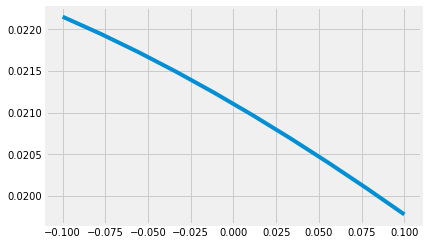

In [ ]:
# inspect NN behaviour
moneyness_grid = np.linspace(-0.1, 0.1, 10).reshape(-1, 1, 1)
inp = tf.Variable(moneyness_grid, dtype=tf.float32)
with tf.GradientTape() as tape:
    preds = model(inp)
grads = tape.gradient(preds, inp)


grads = grads.numpy().reshape(-1)

plt.plot(moneyness_grid.reshape(-1), grads / (K_strike * np.exp(moneyness_grid.reshape(-1))))

In [ ]:
%%time
calc_Heston_delta_by_FD(kappa = 1, theta = 0.04, sigma = 2, rho = -0.7, r = 0, 
                        s0 = Sts[0, 0], v0 = 0.04, K= K_strike, tau = (T - 0) * dt)

CPU times: user 18.8 ms, sys: 1.01 ms, total: 19.8 ms
Wall time: 22.4 ms


0.7086906155162609

In [ ]:
h = 0.0001
(call_price(kappa = 1, theta = 0.04, sigma = 2, rho = -0.7, r = 0, 
                        s0 = Sts[0, 0] + h, v0 = 0.04, K= K_strike, tau = (T - 0) * dt) - call_price(kappa = 1, theta = 0.04, sigma = 2, rho = -0.7, r = 0, 
                        s0 = Sts[0, 0] - h, v0 = 0.04, K= K_strike, tau = (T - 0) * dt)) / (2 * h)

0.7086852332416349

In [ ]:
%%time
vec_fd = np.vectorize(calc_Heston_delta_by_FD)
print(vec_fd(kappa = 1, theta = 0.04, sigma = 2, rho = -0.7, r = 0, 
                        s0 = Sts[:10, :1], v0 = 0.04, K= K_strike, tau = (T - 0) * dt))

[[0.70869062]
 [0.70869062]
 [0.70869062]
 [0.70869062]
 [0.70869062]
 [0.70869062]
 [0.70869062]
 [0.70869062]
 [0.70869062]
 [0.70869062]]
CPU times: user 241 ms, sys: 791 µs, total: 242 ms
Wall time: 243 ms


In [ ]:
with open("heston_deltas.npy", "wb") as f:
  np.save(f, heston_deltas)

# References



+ Weiguan Wang
+ Mathematical Modeling and Computation in Finance
+ Glasserman 
+ Broadie Kaya

## Code References

+ https://github.com/weiguanwang/Hedging_Neural_Networks/blob/master/library/heston.py
+https://github.com/LechGrzelak/Computational-Finance-Course/blob/main/Lecture%2010-%20Monte%20Carlo%20Simulation%20of%20the%20Heston%20Model/Materials/HestonModelDiscretization.py